# Statistical Clear Sky Fitting of Huang PV 2017 Data

Here, the SCSF algorithm is applied to one year of PV power production data from the Huang rooftop at Stanford University. The data were collected at a 1-minute time resolution, so the data matrix is in $\mathbf{R}^{1440\times 365}$. 

First some standard imports and data loading.

In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline

In [2]:
data = np.load('/Users/bennetmeyers/Documents/Data/collab/Huang_2017_data.npy')

In [3]:
data.shape

(1440, 365)

In [4]:
p = data.ravel(order='F')

Viewing the first 6 days of data. Interestingly, the first three days of data appear to be exact copies. However, because these are cloudy days, they will be ignored by the algorithm, and treated the same as if they were all zeros. This is one of the benefits of the robust fitting approach employed by the algorithm.

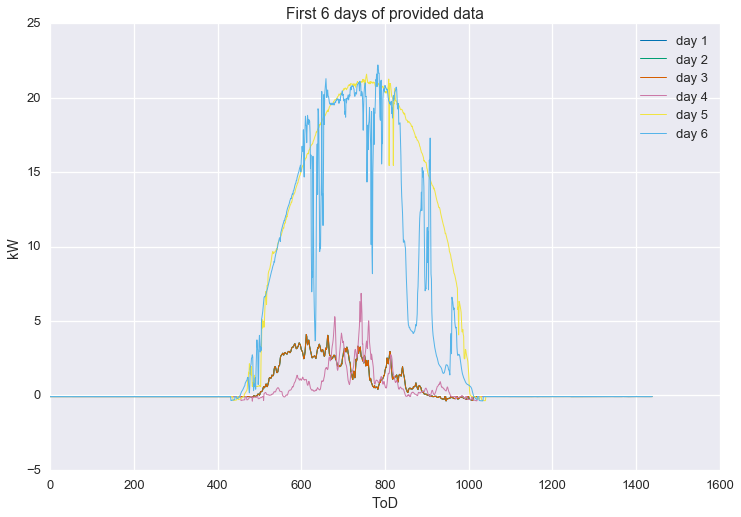

In [5]:
plt.figure(figsize=(12,8))
for i in xrange(6):
    plt.plot(data[:, i], linewidth=1, label='day {}'.format(i+1))
plt.legend()
plt.title('First {} days of provided data'.format(i+1))
plt.ylabel('kW')
plt.xlabel('ToD')
plt.show()

In [6]:
ics = IterativeClearSky(data, k=5)

In [7]:
U, Sig, Vt = np.linalg.svd(data)

In [8]:
ics.mu_L = 1e4
ics.mu_R = 5e3
ics.tau = 0.9
ics.minimize_objective(max_iter=10)

starting at 18966408.683 [24481.09825041786, 5264.080113096101, 18936663.504533302, 0]
iteration 1: 18921.448 [15711.05     30.08   3180.319     0.   ]
iteration 2: 16201.132 [13079.413    70.385  3051.334     0.   ]
iteration 3: 15749.013 [12618.166    93.652  3037.195     0.   ]
iteration 4: 15669.338 [12535.143    97.009  3037.185     0.   ]
iteration 5: 15632.626 [12503.577    97.726  3031.323     0.   ]
iteration 6: 15606.118 [12481.846    98.025  3026.247     0.   ]
iteration 7: 15583.541 [12465.543    97.746  3020.252     0.   ]
iteration 8: 15563.592 [12453.914    97.889  3011.788     0.   ]
iteration 9: 15543.970 [12440.857    98.452  3004.662     0.   ]
iteration 10: 15525.611 [12427.427    99.41   2998.773     0.   ]
Reached iteration limit. Previous improvement: 0.12%
Minimization complete in 8.64 minutes


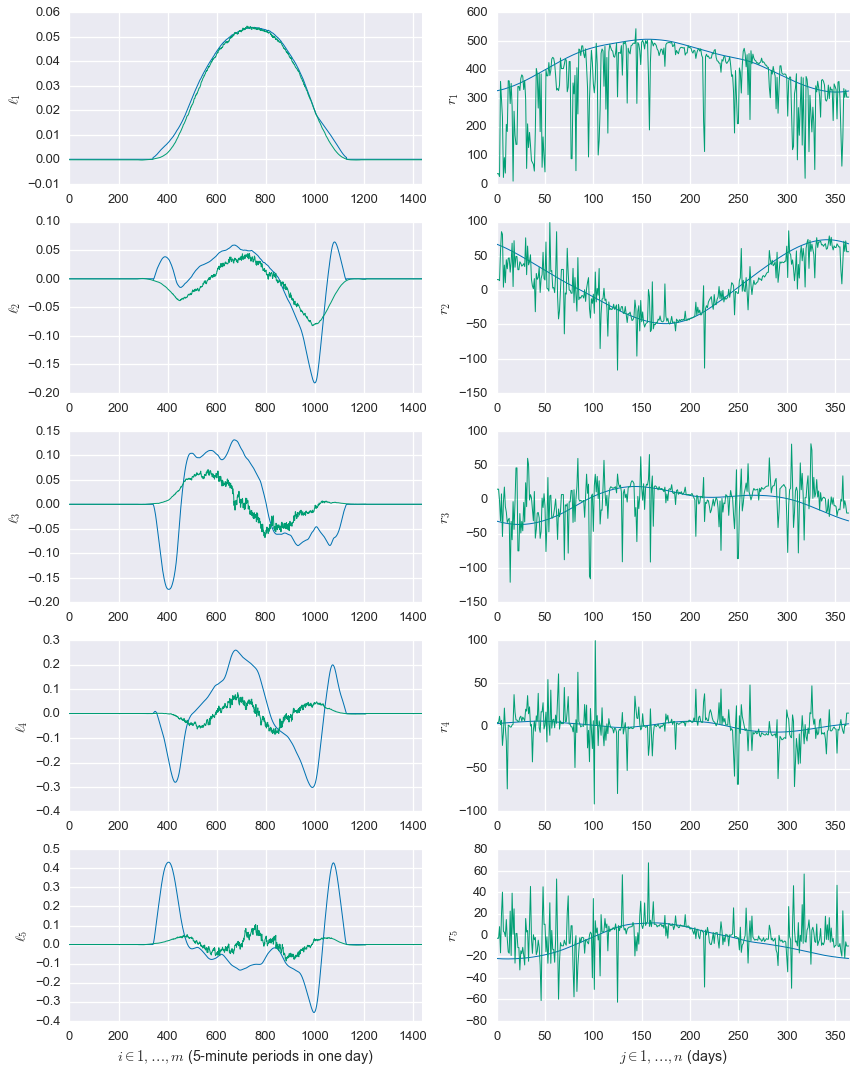

In [9]:
N=5
fig, ax = plt.subplots(nrows=N, ncols=2, figsize=(12,N*3))
for i in xrange(N):
    ax[i][0].plot(ics.L_cs.value.T[i].A1, linewidth=1)
    ax[i][0].set_xlim(0, 1439)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot(ics.R_cs.value[i].A1, linewidth=1)
    ax[i][1].set_xlim(0, data.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
    ax[i][0].plot(U.T[i], linewidth=1)
    ax[i][0].set_xlim(0, 1439)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot((np.diag(Sig).dot(Vt))[i], linewidth=1)
    ax[i][1].set_xlim(0, data.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
ax[-1][0].set_xlabel('$i \\in 1, \\ldots, m$ (5-minute periods in one day)')
ax[-1][1].set_xlabel('$j \\in 1, \\ldots, n$ (days)')
plt.tight_layout()
plt.show()

(0, 5760)

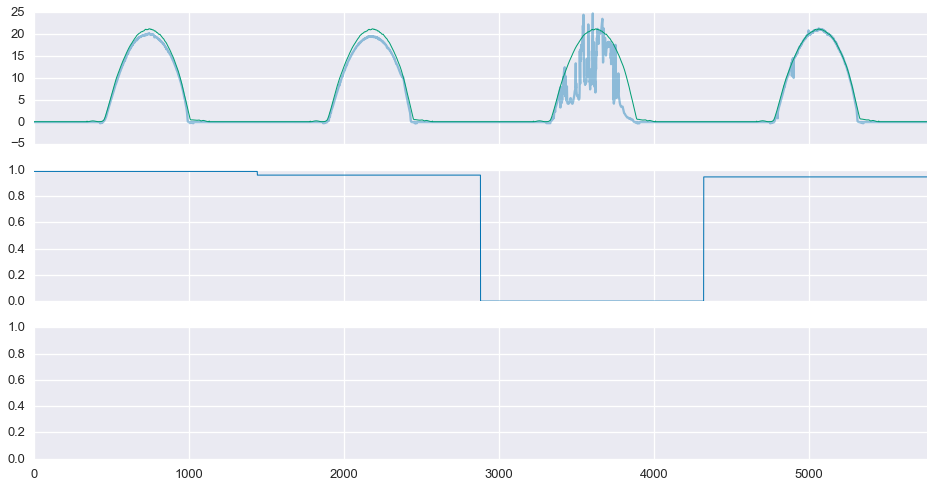

In [10]:
D1 = 350
D2 = D1 + 4
actual = ics.D[:, D1:D2].ravel(order='F')
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F').A1
fig, ax = plt.subplots(nrows=3, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 1440), linewidth=1)
ax[-1].set_xlim(0, 1440*(D2-D1))

Finally, we take a "top-down" view of the raw data used as an input to the algorithm, and the estimated clear sky signal returned by the algorithm.

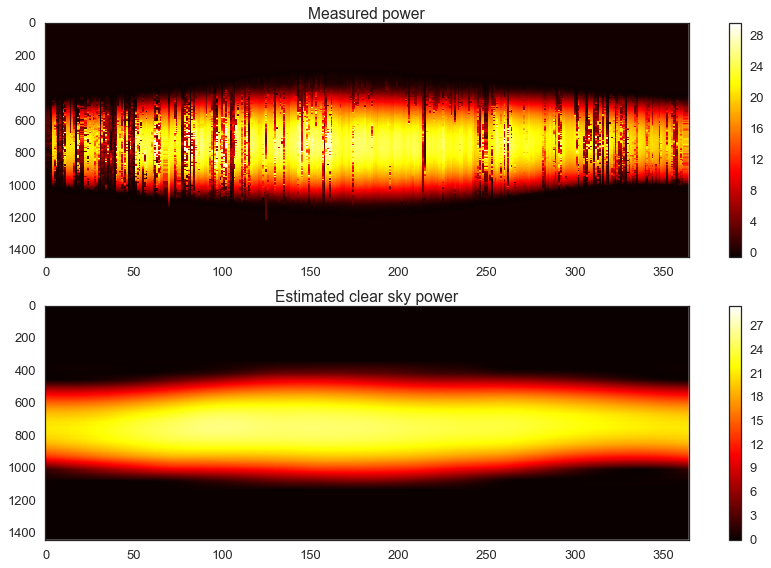

In [11]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(12,8))
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot', vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0])
    plt.colorbar(bar, ax=ax[1])
    plt.tight_layout()

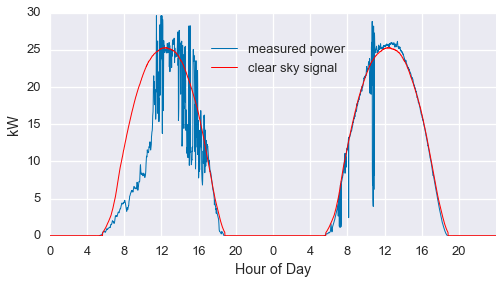

In [12]:
D1 = 130
D2 = D1 + 2
actual = p[D1*1440:D2*1440]
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F').A1
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 1440*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 1440*2, 2*120))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
ax.set_ylim(0,30)
plt.show()

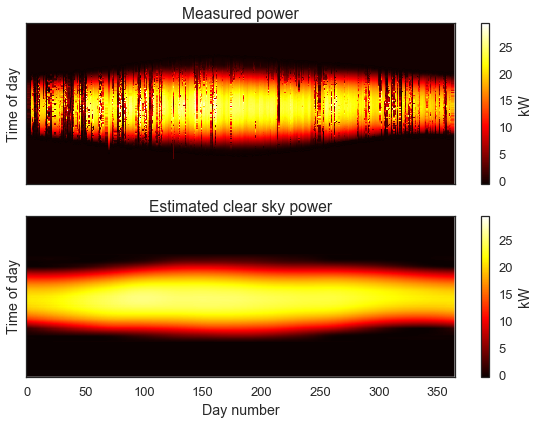

In [13]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot', vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW', ticks=range(0, 30, 5))
    plt.colorbar(bar, ax=ax[1], label='kW', ticks=range(0, 30, 5))
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

In [14]:
print sum(ics.L_cs.size) + sum(ics.R_cs.size)

1815


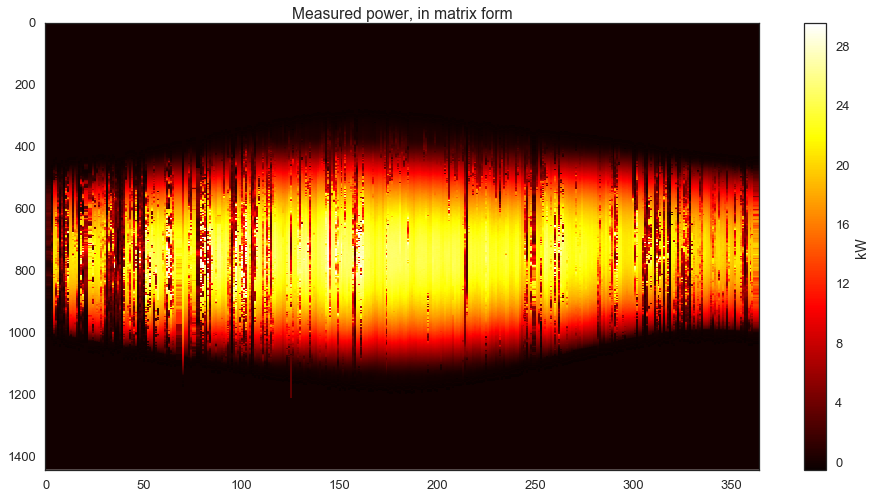

In [15]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(data, cmap='hot', aspect='auto', interpolation='none', vmax=np.max(data))
    plt.colorbar(label='kW')
    plt.title('Measured power, in matrix form')

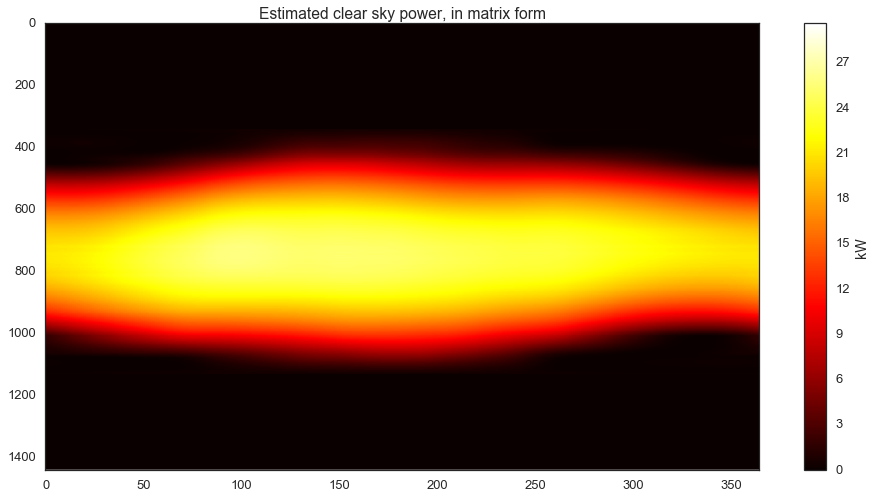

In [16]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot', aspect='auto', interpolation='none', vmax=np.max(data))
    plt.colorbar(label='kW')
    plt.title('Estimated clear sky power, in matrix form')